
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Epoch: 1 Discriminator Loss= 0.175611, Generator Loss= 6.065050,Q_loss=0.034409, Avg Loss=4.199840
Epoch: 2 Discriminator Loss= 0.669162, Generator Loss= 1.663198,Q_loss=0.021722, Avg Loss=3.801133
Epoch: 3 Discriminator Loss= 0.560764, Generator Loss= 2.243222,Q_loss=0.002170, Avg Loss=3.125632
Epoch: 4 Discriminator Loss= 0.944649, Generator Loss= 1.121137,Q_loss=0.000455, Avg Loss=2.538818
Epoch: 5 Discriminator Loss= 1.267524, Generator Loss= 0.814911,Q_loss=0.000055, Avg Loss=2.375849
Epoch: 6 Discriminator Loss= 0.467

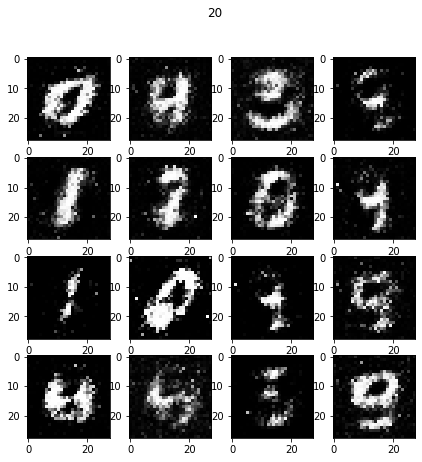

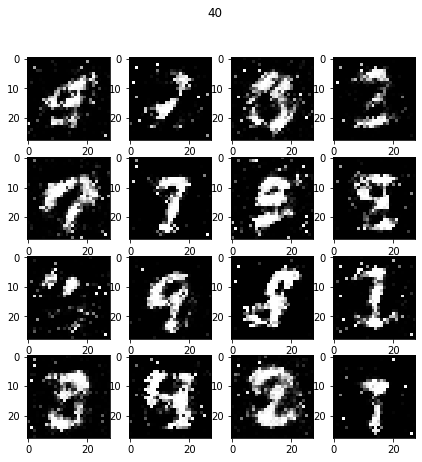

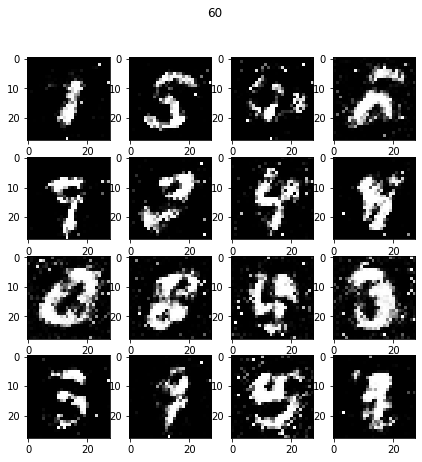

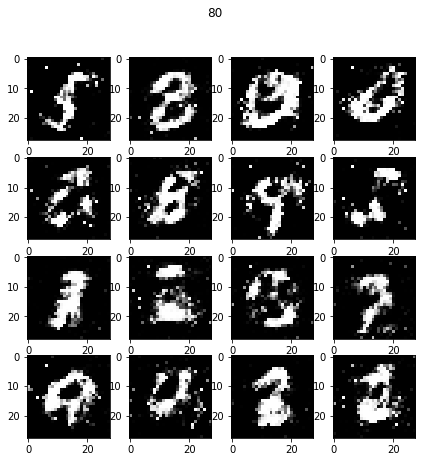

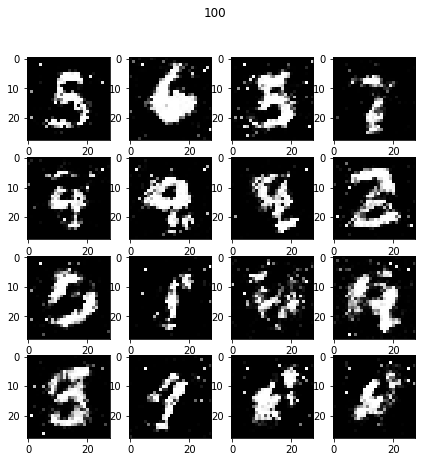

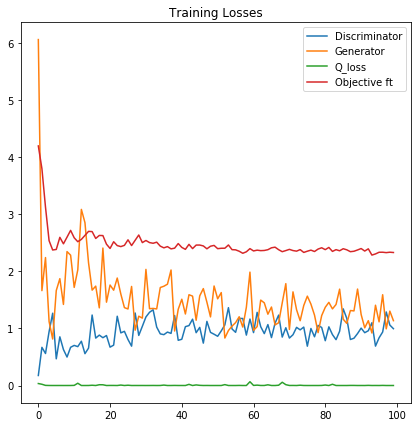

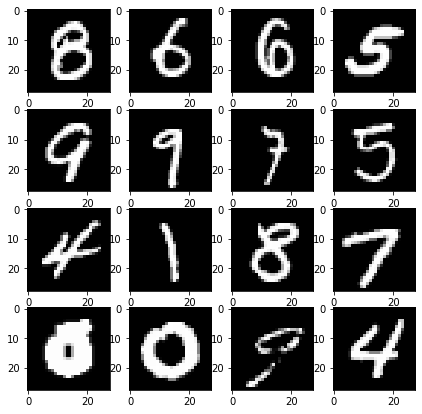

In [1]:
# 필요한 라이브러리 불러들임 a
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
%matplotlib inline

# 그래프 리셋
tf.reset_default_graph() 
# 재현성을 위해 시드 지정
tf.set_random_seed(1)

#--------------------------------------------------
# data 불러오기
#--------------------------------------------------

# data load
f1 = open ('./mnist6000/traindata.txt','r')
X0 =[]
X0 =[line.split()for line in f1]
f1.close()
Ximg=np.array(X0, dtype=np.float32)

 
# 관측치 수 (=5000)
sample_size=Ximg.shape[0] 
# 입력 변수 수 (=784)
input_dim = Ximg.shape[1] 

#-------------------------------------------
# 매개변수 설정
#-------------------------------------------
# 입력 잡음신호의 차원: 100
# 생성자의 두 은닉층 크기: 128
# 비판자의 두 은닉층 크기: 128
# 미니배치 크기: 20
# 반복 수: 100
# 학습률 : 0.01
# # 잠재적 특징 크기: 3

learning_rate = 0.001 # 학습률
batch_size = 20 #배치크기
z_size =100 # 잡음 크기
C_size=4 # 잠재적 특징 크기
nepochs = 100 # 반복 수 
g_hidden_size = 128 # 생성자 은닉층 노드 수 
d_hidden_size = 128 # 판별자 은닉층 노드 수 
alpha=0.1 # Leaky ReLu 모수, alpha=0 --> ReLu

# 드랍아웃 보존 비율
keep_prob = tf.placeholder(tf.float32,name='keep_prob')

# 진짜데이터 placeholder 
X = tf.placeholder(tf.float32, shape=[None, input_dim], name='X')
# 잡음 플레이스 홀더
Z = tf.placeholder(tf.float32, shape=[None, z_size], name='Z')
# 잠재적 특징 플레이스 홀더
C = tf.placeholder(tf.float32, shape=[None, C_size], name='C')

# 판별자의 가중치와 편의 정의(# 사비에르 초기치 사용)
D_W1 = tf.get_variable('D_W1',shape=[input_dim,d_hidden_size],initializer=tf.contrib.layers.xavier_initializer())
D_b1 = tf.Variable(tf.random_normal([d_hidden_size]), name='D_b1')
D_W2 = tf.get_variable('D_W2',shape=[d_hidden_size,1],initializer=tf.contrib.layers.xavier_initializer())
D_b2 = tf.Variable(tf.random_normal([1]), name='D_b2')
theta_D = [D_W1, D_W2, D_b1, D_b2]


# 생성자의 가중치와 편의 정의(# 사비에르 초기치 사용)
G_W1 = tf.get_variable('G_W1',shape=[z_size + C_size, g_hidden_size],initializer=tf.contrib.layers.xavier_initializer())
G_b1 = tf.Variable(tf.zeros(shape=[g_hidden_size]), name='G_b1')
G_W2 = tf.get_variable('G_W2',shape=[g_hidden_size,input_dim],initializer=tf.contrib.layers.xavier_initializer())
G_b2 = tf.Variable(tf.zeros(shape=[input_dim]), name='G_b2')
theta_G = [G_W1, G_W2, G_b1, G_b2]


# 변환 추론법의 Q-망에 사용되는 가중치와 편의 정의(# 사비에르 초기치 사용)
# (많은 경우에 판별망과 같이 사용하지만 여기에서는 별도로 지정함)
Q_W1 = tf.get_variable('Q_W1',shape=[input_dim,d_hidden_size],initializer=tf.contrib.layers.xavier_initializer())
Q_b1 = tf.Variable(tf.random_normal([d_hidden_size]), name='Q_b1')
Q_W2 = tf.get_variable('Q_W2',shape=[d_hidden_size,C_size],initializer=tf.contrib.layers.xavier_initializer())
Q_b2 = tf.Variable(tf.random_normal([C_size]), name='Q_b2')
theta_Q = [Q_W1, Q_W2, Q_b1, Q_b2]

#------------------------------------------------
# 생성자 정의: 입력된 진짜 이미지와 유사한 가짜 이미지 생성
#------------------------------------------------
def generator(z,c):
    with tf.variable_scope('generator'):
        zc=tf.concat([z,c],axis=1)
        h1=tf.matmul(zc, G_W1) + G_b1        
        h1 = tf.maximum(alpha*h1, h1) 
        h2 = tf.matmul(h1, G_W2) + G_b2
        out = tf.nn.tanh(h2) 
        return out

#------------------------------------------------
# 판별자 정의: 입력된 진짜 데이터와 가짜 데이터를 정확하게 분류
#------------------------------------------------
def discriminator(x):
    with tf.variable_scope('discriminator'):
        h1=tf.matmul(x, D_W1) + D_b1        
        h1 = tf.maximum(alpha*h1, h1)    
        h1=tf.nn.dropout(h1, keep_prob)
        h2 = tf.matmul(h1, D_W2) + D_b2
        h2=tf.nn.dropout(h2, keep_prob)
        probD = tf.nn.sigmoid(h2)
        return probD, h2
#------------------------------------------------
# Q망 정의 (사후확률 추정) 
#------------------------------------------------   
def Q(x):
        h1=tf.matmul(x, Q_W1) + Q_b1        
        h1 = tf.maximum(alpha*h1, h1)    
        h1=tf.nn.dropout(h1, keep_prob)
        h2 = tf.matmul(h1, Q_W2) + Q_b2
        h2=tf.nn.dropout(h2, keep_prob)
        probQ = tf.nn.softmax(tf.matmul(h1, Q_W2) + Q_b2)
        return probQ
            
# 가짜데이터
G = generator(Z,C)
# 진짜데이터의 판별자 결과
D_real, D_logit_real = discriminator(X)
# 가짜데이터의 판별자 결과
D_fake, D_logit_fake = discriminator(G)
# Q망 결과 Q(c|x)
Q_c=Q(G)

# 비용함수 = D_loss+G_loss - lambda*LowLimit_mInfo

# 진짜데이터의 판별망 비용함수
D_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_real, labels=tf.ones_like(D_logit_real)))
# 가짜데이터의 판별망 비용함수
D_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=tf.zeros_like(D_logit_fake)))
# 판별망의 비용함수
D_loss = D_loss_real + D_loss_fake
# 가짜데이터의 생성망 관점에서의 비용함수 
G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=tf.ones_like(D_logit_fake)))

# LoBMI(상호정보량의 하한) =  E_{c~P(c)}E_{x~P_g} {log(Q(c|x))} + H(c), 
# The entropy of c: H(c) = - ∑ P(c) * log(P(c)), 상수
# entropy=np.log(C_size), c~multinomial(1,1/C_size)
# entropy=log(2), c~Unif(-1,1) 
LoBMI = tf.reduce_mean(-tf.reduce_sum(tf.log(Q_c+ 1e-10 )*C, 1))

Q_loss=LoBMI # min Q_loss <--> max LoBMI 

T_vars = tf.trainable_variables() 
D_vars = [var for var in T_vars if 'D_' in var.name]
G_vars = [var for var in T_vars if 'G_' in var.name] 
Q_vars = [var for var in T_vars if 'Q_' in var.name]

# Optimizer 
D_solver = tf.train.AdamOptimizer(learning_rate).minimize(D_loss, var_list=D_vars)
G_solver = tf.train.AdamOptimizer(learning_rate).minimize(G_loss, var_list=G_vars)
Q_solver = tf.train.AdamOptimizer(learning_rate).minimize(Q_loss, var_list=G_vars+Q_vars)

#------------------------------------------------
# 텐서플로 그래프 생성 및 학습 
#------------------------------------------------
sess=tf.Session(); 
sess.run(tf.global_variables_initializer())

losses = []
for epoch in range(nepochs):
    total_batch=int(sample_size/batch_size)
    avg_loss=0
    for ii in range(total_batch):
        if ii!=total_batch:
              batch_images=Ximg[ii*batch_size:(ii+1)*batch_size]
        else:
              batch_images=Ximg[(ii+1)*batch_size:]           
        batch_images = batch_images*2 - 1   
        batch_z = np.random.uniform(-1, 1, size=(batch_size, z_size)) 
        c_noise= np.random.multinomial(1, C_size*[1./C_size], size=batch_size)
        sess.run(D_solver, feed_dict={X: batch_images, Z: batch_z,C:c_noise,keep_prob:0.9})
        sess.run(G_solver, feed_dict={Z: batch_z,C:c_noise,keep_prob:0.9})         
        sess.run(Q_solver, feed_dict={Z: batch_z,C:c_noise,keep_prob:0.9})
        D_loss_curr = sess.run(D_loss, feed_dict={X: batch_images, Z: batch_z,C:c_noise,keep_prob:0.9})
        G_loss_curr = sess.run(G_loss, feed_dict={Z: batch_z,C:c_noise,keep_prob:0.9})    
        Q_loss_curr = sess.run(Q_loss, feed_dict={Z: batch_z,C:c_noise,keep_prob:0.9})
        losss=D_loss_curr+G_loss_curr+Q_loss_curr
        avg_loss+=losss/total_batch
    print('Epoch: %d' %(epoch+1),'Discriminator Loss= %f, Generator Loss= %f,Q_loss=%f, Avg Loss=%f'
          %(D_loss_curr, G_loss_curr, Q_loss_curr,avg_loss))
    losses.append((D_loss_curr, G_loss_curr,Q_loss_curr,avg_loss))        
    # 100 에폭마다 가짜 이미지 그림
    if (epoch+1)%20==0:
        tf.set_random_seed(0)
        sample_z = np.random.uniform(-1, 1, size=(16,z_size))
        sample_c=np.random.multinomial(1, C_size*[1./C_size], size=16)
        gen_samples = sess.run(G,feed_dict={Z: sample_z,C:sample_c})
        f,axes =plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
        f.suptitle(epoch+1)
        for ii in range(16):
            plt.subplot(4,4,ii+1)
            plt.imshow(gen_samples[ii].reshape((28,28)), cmap='Greys_r')

# 비판자, 생성자의 비용함수 그림 
fig, ax = plt.subplots(figsize=(7,7))
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.plot(losses.T[2], label='Q_loss')
plt.plot(losses.T[3], label='Objective ft')

plt.title("Training Losses")
plt.legend()

   
f,axes =plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
for ii in range(16):
    plt.subplot(4,4,ii+1)
    plt.imshow(Ximg[ii].reshape(28,28),cmap='Greys_r')